# KDE smoothing using seaborn

This notebook aims to provide a variable color map in a kdeplot

## Imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
df_iris = sns.load_dataset('iris')

## Iris data set testing

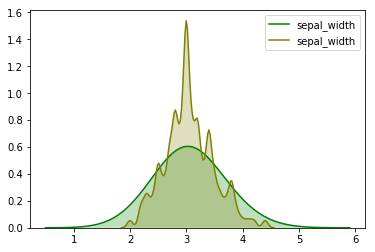

In [3]:
# Large bandwidth
sns.kdeplot(df_iris['sepal_width'], shade=True, bw=.5, color="green")
#plt.show()
 
# Narrower bandwidth
sns.kdeplot(df_iris['sepal_width'], shade=True, bw=.05, color="olive")
#sns.plt.show()

In [4]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


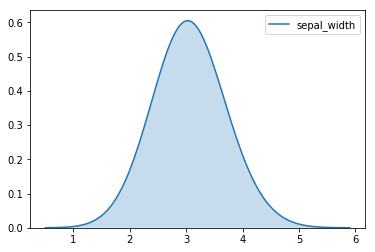

In [5]:
sns.kdeplot(df_iris['sepal_width'],
            shade=True,
            bw=0.5,
            vertical=False,
            kernel='gau',
            gridsize=100,
            cut=3,
            clip=None,
            legend=True,
            cumulative=False,
            shade_lowest=True,
            cbar=False,
            cbar_ax=None,
            cbar_kws=None
           )
plt.show()

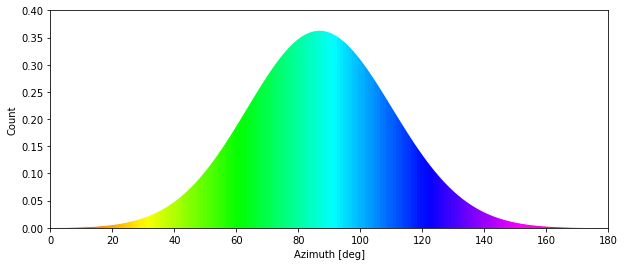

In [6]:
# Make figure
fig, ax = plt.subplots(figsize=(10, 4))

# Get data
data_iris = df_iris['sepal_width'].values
data_iris[-1] = data_iris[0]  # Force circular by repeating one.
azis = np.linspace(0, 180, 13)
_ , y = sns.kdeplot(data_iris, bw=1, lw=0).get_lines()[0].get_data()
x = np.linspace(0, 180, y.size)

# Make background image.
azi_180 = np.linspace(0, 180, 181)
azi_img = np.tile(azi_180, int(max(data_iris)+1)).reshape(int(max(data_iris)+1), -1)
img = ax.imshow(azi_img, cmap='hsv', origin='lower', aspect='auto')

# Plot line and masking fill.
line = ax.plot(x, y, lw=0)
poly = ax.fill_between(x, y, max(data_iris)+1, color='w')
text = ax.set_xlabel("Azimuth [deg]")
text = ax.set_ylabel("Count")
plt.xlim(0, 180)
plt.ylim(0,np.round(np.max(y)+np.max(y)*0.1, decimals=2))
plt.show()

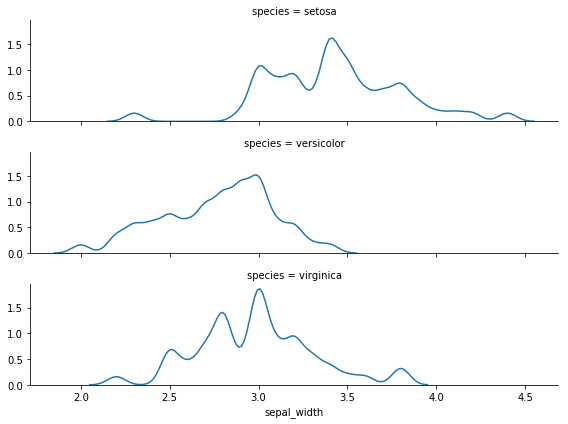

In [7]:
g = sns.FacetGrid(df_iris, row='species', height=2, aspect=4)
g.map(sns.kdeplot, 'sepal_width', shade=False, bw=0.05,)
plt.show()

## Fake fracture data testing

In [8]:
def create_fake_data(n_locs=5, n_orients=5):
    """
    create a fake data set for testing
    args:
        - number of locations (int)
        - number of orientations (int)
    returns:
        pandas DataFrame
    """
    # generate locations
    locations = np.arange(0,n_locs,1)

    # generate orientations for each location
    data = {}
    for loc in locations:
        orientations = np.random.randint(0,180,size=n_locs)
        data[loc] = orientations
    
    # generate DataFrame
    df_out_wide = pd.DataFrame(data)
    
    # reshape dataframe
    df_out = df_out_wide.melt()
    
    # change colum names
    df_out.rename(index=str, columns={"variable": "location", "value": "orientation"}, inplace=True)
        
    return df_out

In [9]:
df_fracs = create_fake_data(n_locs=25, n_orients=25)
df_fracs.tail()

,location,orientation
620,24,112
621,24,75
622,24,4
623,24,71
624,24,97


In [10]:
def plot_frac_azis(df, start_location=0, end_location=0, bw=0.5):
    """
    plot fracture azimuths for a range of locations between start_location and end_location
    by default all data are plotted
    args:
        dataframe, selection of locations from dataframe as a list of indexes
    returns:
        FacetGrid plot
        
    TODO:
        - find a symmetrical colormap to better represent azimuths
        - fix the label and title sizes
    """
    # slice into Dataframe
    df_fracs = df.iloc[np.where((df['location'] >= start_location) &
                                (df['location'] <= end_location))]
    
    # define the plot labels
    labels = df_fracs.location.unique()
    
    # make colormap
    cmap = sns.color_palette(palette='husl')
    
    # set up the FacetGrid with a given color map
    g2 = sns.FacetGrid(df_fracs, row='location', height=2, aspect=12, palette=cmap)
    
    # map the sns.kdeplot onto the FacetGrid and set up plot axes
    g2.map(sns.kdeplot, 'orientation', shade=True, bw=bw, gridsize=180, )

    g2.despine(top=True, right=True, left=False, bottom=False)
    g2.set_axis_labels(x_var='Fracture azimuth')
    axes = g2.axes.flatten()
    for ax in enumerate(axes):
        ax[1].set_ylabel(f'count: {labels[ax[0]]}')
    plt.subplots_adjust(top=0.85)
    g2.fig.suptitle('Fracture orientations by locations')
    g2.set_titles(row_template='')

    return plt.show()


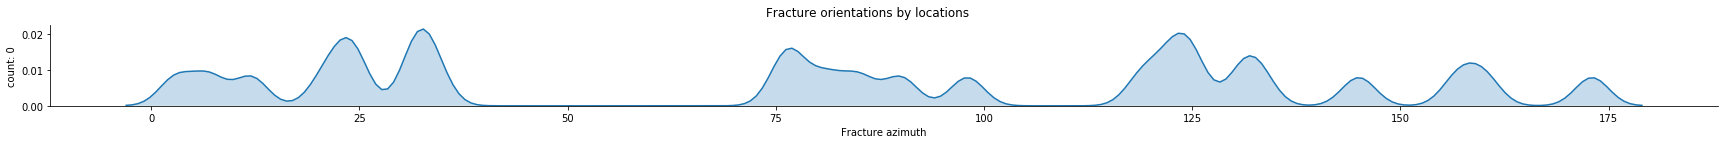

In [11]:
plot_frac_azis(df_fracs, start_location=0, end_location=0, bw=2)

### Testing variable fill in kdeplot

#### Nota Bene

The code in the next cell does not work, I have _not_ been able to get this working with `FacetGrid()`, so the next step is to try a loop.

In [ ]:
# make figure
fig, ax = plt.subplots(figsize=(10, 4))

# Make fake data.
data = np.random.randint(0, 20, size=13)
data[-1] = data[0]  # Force circular by repeating one.
azis = np.linspace(0, 180, 13)
_ , y = sns.kdeplot(data, bw=1, lw=0).get_lines()[0].get_data()
x = np.linspace(0, 180, y.size)

# Make background image.
azi_180 = np.linspace(0, 180, 181)
azi_img = np.tile(azi_180, max(data)+1).reshape(max(data)+1, -1)
img = ax.imshow(azi_img, cmap='hsv', origin='lower', aspect='auto')

# Plot line and masking fill.
line = ax.plot(x, y, lw=0)
poly = ax.fill_between(x, y, max(data)+1, color='w')
text = ax.set_xlabel("Azimuth [deg]")
text = ax.set_ylabel("Count")
plt.xlim(0, 180)
plt.ylim(0,np.round(np.max(y)+np.max(y)*0.1, decimals=2))
plt.show()

In [ ]:
def make_clever_plot(ax, data):
    <do clever things>
    ax.plot(data)
    <do more clever things>
    return ax

fig, axs = plt.subplots(nrows=number_of_plots)

for ax, data in zip(axs, datasets):
    ax = make_clever_plot(ax, data)

In [132]:
def make_frac_plot(ax, data_arr, bw=0.5, angle_bins=15):
    """
    attempt to plot frac az kdeplots with circular color map fills
    the start_loc and end_loc are half open consistent with Python slicing
    """

    # get data and create kdeplot
    data = data_arr
    num = 180 // angle_bins + 1
    azis = np.linspace(0, 180, num=num)
    _, y = sns.kdeplot(data, bw=bw, lw=0).get_lines()[0].get_data()
    x = np.linspace(0, 180, y.size)

    # Make background image.
    azi_180 = np.linspace(0, 180, 181)
    azi_img = np.tile(azi_180, max(data)+1).reshape(max(data)+1, -1)
    img = ax.imshow(azi_img, cmap='hsv', origin='lower', aspect='auto')

    # Plot line and masking fill.
    line = ax.plot(x, y, lw=0)
    poly = ax.fill_between(x, y, max(data)+1, color='w')
    ax.set_xlabel("Azimuth [deg]")
    ax.set_ylabel("kde")
    plt.xlim(0, 180)
    plt.ylim(0,np.round(np.max(y)+np.max(y)*0.1, decimals=2))
    
    return


In [148]:
def stack_frac_plots(df, start_loc=0, end_loc=0, bw=0.5, angle_bins=15):
    """
    stack fracture azimuth plots
    """
    # set variables and get data
    locs = range(start_loc, end_loc)
    datasets = np.array([df.iloc[np.where(df.location == loc)].orientation.values for loc in locs])
    
    num_plots = end_loc - start_loc

    # set up figure
    fig, axs = plt.subplots(figsize=(16,4), nrows=num_plots)

    # plot in axes
    try:
        for ax, data in zip(axs, datasets):
            ax = make_frac_plot(ax, data, bw, angle_bins)
    except TypeError:
        print('Please make at least two plots.\nNote that the [start_loc:end_loc] slice is half open.')
        ax = None
        pass
    
    return ax

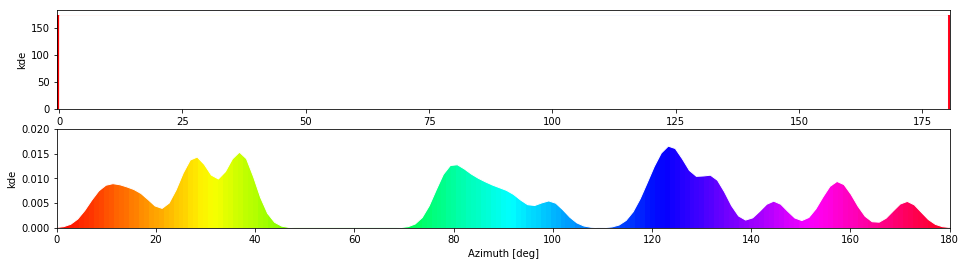

In [150]:
stack_frac_plots(df_fracs, start_loc=0, end_loc=2, bw=3, angle_bins=15)

## Real data from user

In [ ]:
# read real data in
df_swift_raw = pd.read_csv('../data/adam_fracs/swift_orientations.csv')
df_swift_raw.head()

In [ ]:
def clean_data(df):
    """
    Return a formatted dataframe for use in analysis
    args:
        - dataframe
    returns:
        - dataframe
        - array of unique variables
    """
    # clean data
    df_out = df.melt()
    df_out.sort_values('variable', inplace=True)
    df_out.dropna(inplace=True)
    df_out.reset_index(inplace=True, drop=True)
    df_out['variable'] = df_out['variable'].astype(float)
    
    # get uniques
    uniques = np.sort(df_out['variable'].unique())
    
    return df_out, uniques
    

In [ ]:
df_swift, swift_uniques = clean_data(df_swift_raw)
df_swift.head()

In [ ]:
swift_uniques

In [ ]:
plot_frac_azis(df_swift, start_location=7221, end_location=7221, bw=3)

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div>